In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import scipy.io
from sympy import *
from scipy.linalg import block_diag # numpy does not provide this functionality
init_session()

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

IPython console for SymPy 1.0 (Python 2.7.12-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.0/


# Importing Packages and Reading In CSV's #

In [42]:
# The mandrill picture is a 480 x 500 x 3 image. We need a numpy array that is of that size.
mandrill = np.zeros((480, 500, 3))
with open("mandrill_X.csv") as f:
    # The mandrill_X is a 480 x 500 index map.
    # The -1 is because there is a new line at the very bottom.
    ind = np.array([int(x) for x in f.read().replace("\n", ",").split(",")[:-1]], dtype=np.int)
    ind = np.reshape(ind, (480, -1))
with open("mandrill_map.csv") as f:
    # The mandrill_map is a 220 x 3 map of colors.
    # The -1 is because there is a new line at the very bottom.
    color = np.array([float(x) for x in f.read().replace("\n", ",").split(",")[:-1]])
    color = np.reshape(color, (220, -1))

## Merge Mandrill_X and Mandrill_map together. (But bad because no vectorization)##

In [4]:
x, y = ind.shape
max_color = 0
for i in xrange(x):
    for j in xrange(y):
        mandrill[i,j,:] = color[ind[i,j]-1]

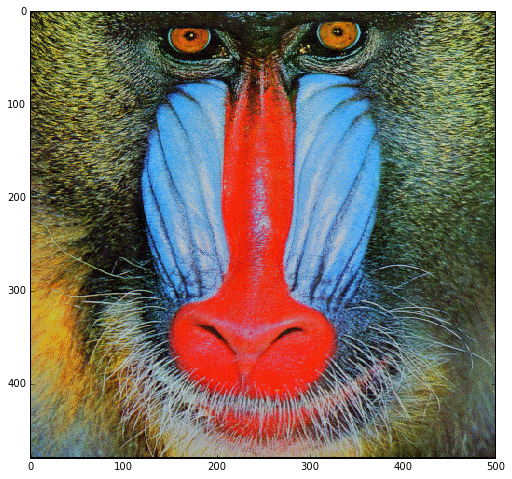

In [5]:
plt.imshow(mandrill)

### Creating a grayscale image ###

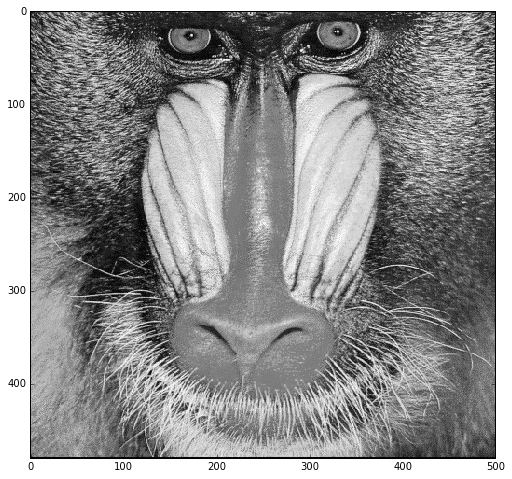

In [25]:
def grayscale(A):
    x, y, z = A.shape
    gray_im = np.sum(A, 2)/3
    return gray_im

grey_mandrill = grayscale(mandrill)
plt.imshow(grey_mandrill)

### Creating an oversaturated image ###

The function is $(1−t)A + tB$.

[ 0.02929688  0.02929688  0.02929688]


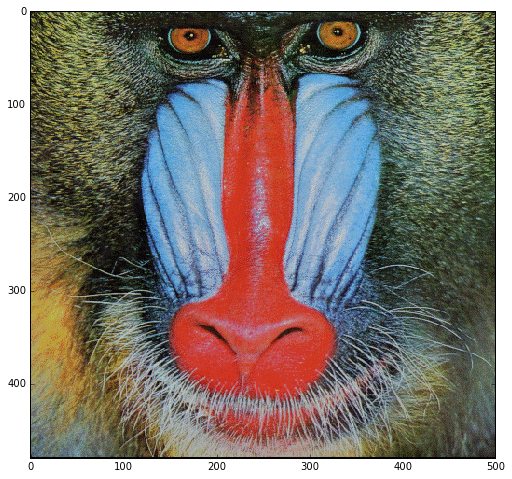

In [26]:
def oversaturate(A, t):
    # Assuming imA.shape[:2] == imB.shape[:2]
    B = grayscale(A)
    x, y = B.shape
    channeled_B = np.repeat(t*B, 3).reshape(x,y,-1)
    print channeled_B[5,5,:]
    return (1-t)*A + channeled_B

plt.imshow(oversaturate(mandrill, 0.25))

### Brightening an image(or darkening it ###

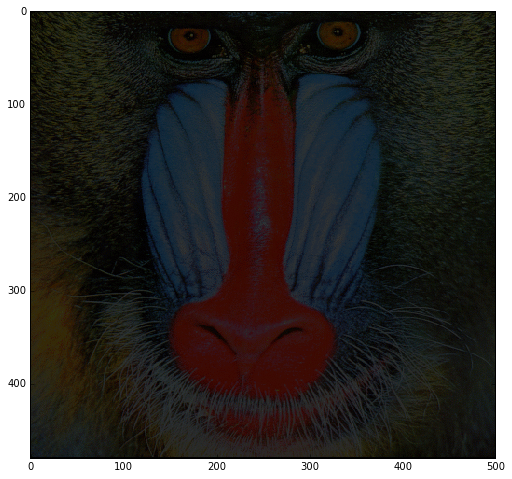

In [29]:
def brighten(A, t):
    return A*t

plt.imshow(brighten(mandrill, 0.25))

# Color Models #

Turn RGB to YCrBr. It is modeled by the following:

T = [[0.29900, 0.58700, 0.11400],

 [-0.16872, -0.33126, 0.50000],
 
 [0.50000, -0.41869, -0.08131]]


$\begin{bmatrix}
Y \\
C_b \\
C_r \end{bmatrix}$ = T.dot($\begin{bmatrix} R \\ G \\ B \end{bmatrix}$) + $\begin{bmatrix} 0 \\ 128 \\ 128 \end{bmatrix}$

### a) prove entries are in range 0 to 255, given R,G,B are. ###

We can see that for the first row, we have the linear combination:

$Y = 0.29900 * R + 0.58700 * G + 0.11400 * B$

We can see that 0.299+0.587+0.114 = 1.

The maximum of the values $R,G,B$ are 255. This means the maximum $Y$ can be is 1 * 255. This proves Y is in the range of 0 to 255. There are no negative linear coefficients so it can't be less than 0.

$C_b = -0.16874 * R + -0.33126 * G + 0.5 * B$

The maximum of the values are 127.5. Rounded down because of property of integer, we have 127.
The minimum of the values are -127.5. Rounded down because of property of integer, we have -128.

Now, we add all values with the scalar 128. This makes our bounds from (-128, 127) to (0, 255).

$C_r = 0.5 * R + -0.41869 * G + -0.08131 * B$

Same idea as the one above. We have the range (-128, 127), turned into (0, 255) from scalar addition with the 128.

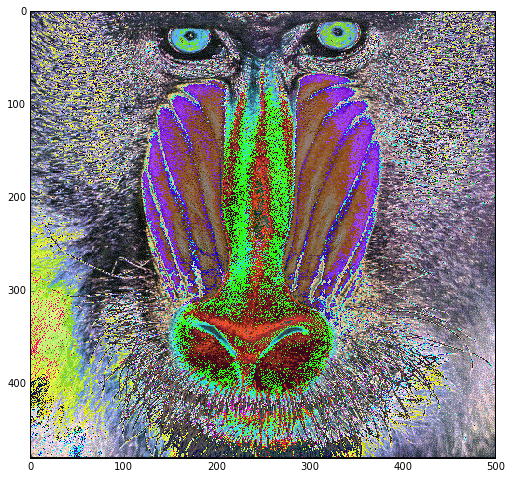

In [34]:
def RGBtoCMY(im):
    return im.dot(np.array([[0,1,1],[1,0,1],[1,1,0]]))

mandrill_cmy = RGBtoCMY(mandrill)
plt.imshow(mandrill_cmy)

# Symbolic computation for Euler Angles #

In [43]:
theta, phi, psi = symbols("theta phi psi")
rot_1 = Matrix([[cos(theta), -sin(theta), 0],[sin(theta), cos(theta), 0], [0, 0, 1]])
rot_2 = Matrix([[1, 0, 0],[0, cos(phi), -sin(phi)],[0, sin(phi), cos(phi)]])
rot_3 = Matrix([[cos(psi), -sin(psi), 0],[sin(psi), cos(psi), 0], [0, 0, 1]])
rot_1 * rot_2 * rot_3

⎡-sin(ψ)⋅sin(θ)⋅cos(φ) + cos(ψ)⋅cos(θ)  -sin(ψ)⋅cos(θ) - sin(θ)⋅cos(φ)⋅cos(ψ) 
⎢                                                                             
⎢sin(ψ)⋅cos(φ)⋅cos(θ) + sin(θ)⋅cos(ψ)   -sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)⋅cos(θ) 
⎢                                                                             
⎣            sin(φ)⋅sin(ψ)                          sin(φ)⋅cos(ψ)             

 sin(φ)⋅sin(θ) ⎤
               ⎥
 -sin(φ)⋅cos(θ)⎥
               ⎥
     cos(φ)    ⎦